In [204]:
import transformers
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer, AutoConfig
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP

from collections import OrderedDict
from operator import itemgetter
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Load models

In [2]:
model_path = 'google/flan-t5-small'
saved_weights = '../storage/llm_gtl_nbr_env_32_Flan_T5small_nbr_actions_3_shape_reward_beta_0_seed_1/model.checkpoint'

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [4]:
finetuned_weights = torch.load(saved_weights)

In [5]:
state_dict = OrderedDict({
    k.replace('module._LLM_model.', ''): v for k, v in finetuned_weights.items() if k.startswith('module._LLM_model')
})

In [6]:
finetuned_model = deepcopy(model)

In [7]:
finetuned_model.load_state_dict(state_dict)

<All keys matched successfully>

# Weights comparison

In [28]:
def gather_distances_by_block(distance_dict):
    _distances = {}
    for weight_matrix_key, distance in distance_dict.items():
        if "block." in weight_matrix_key:
            name_sections = weight_matrix_key.split(".")
            block_idx = name_sections.index("block") + 1
            name = ".".join(_section for _idx, _section in enumerate(name_sections) if _idx not in [block_idx-1, block_idx])
            if name not in _distances:
                _distances[name] = []              
            _distances[name].append(distance)
        else:
            _distances[weight_matrix_key] = [distance]
    return _distances

In [27]:
distances = {}
for weight_matrix_key in model.state_dict().keys():
    distance = torch.abs(model.state_dict()[weight_matrix_key] - finetuned_model.state_dict()[weight_matrix_key]).mean().item()
    distances[weight_matrix_key] = distance

In [29]:
gathered_distances = gather_distances_by_block(distances)

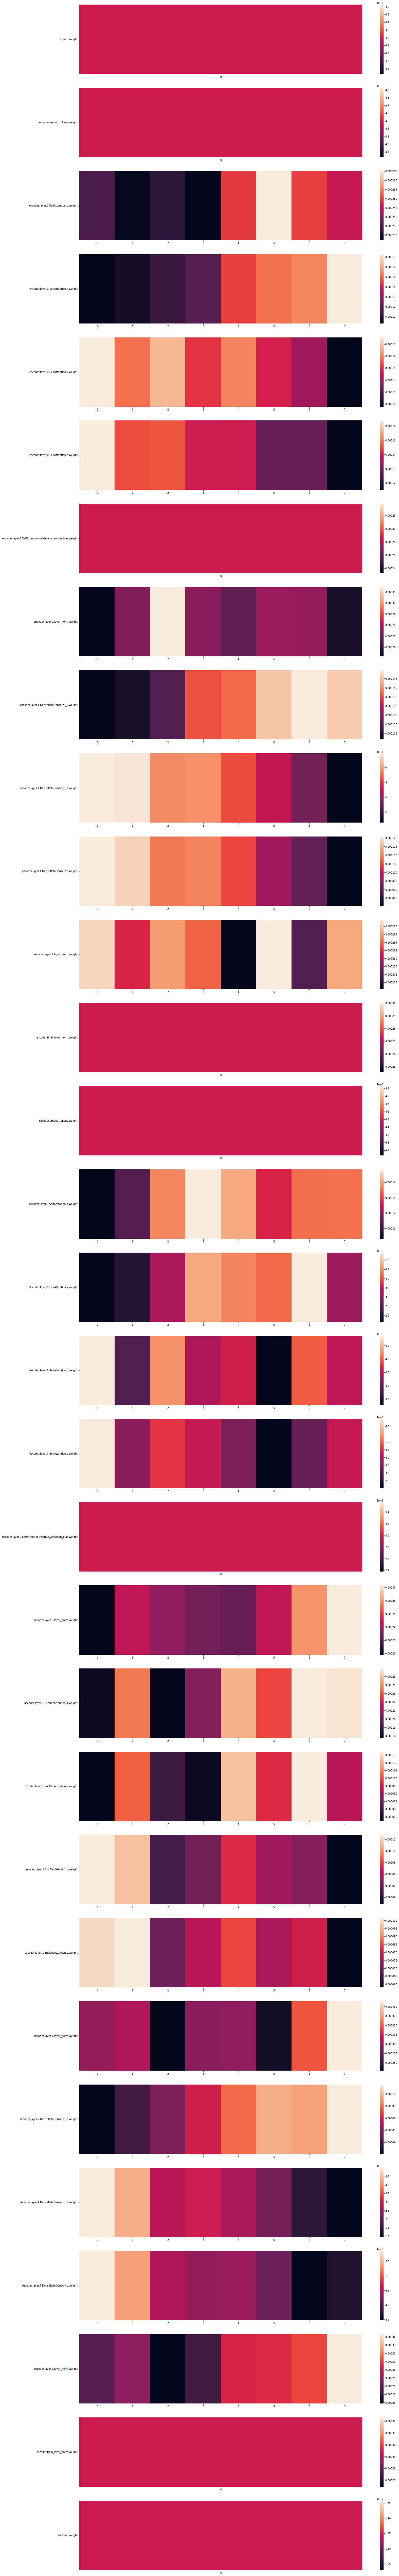

In [53]:
fig, axs = plt.subplots(len(gathered_distances.keys()))
fig.set_figwidth(25)
fig.set_figheight(6*len(gathered_distances.keys()))
j = 0
for k, v in gathered_distances.items():
    sns.heatmap([v], xticklabels=[i for i in range(len(v))], ax=axs[j])
    axs[j].set_yticklabels([k], rotation=0, fontsize="10", va="center")
    j += 1
plt.savefig('test.png', bbox_inches='tight', dpi=100)

## Analysis
ENCODER:
- impact of layer on k,v,o for self-attention
- layer-norm => no clear impact
- impact of layer on MLP

DECODER:
- some impact on self-attention and MLP (less obvious though)

# Representations comparison

In [55]:
prompts = [' \n Goal of the agent: go to the green ball \n Observation 0: A wall 2 step left, A purple key 1 step left and 2 steps forward, A yellow key 1 step left and 1 step forward, A green ball 3 steps forward, A grey ball 1 step right and 5 steps forward, A green key 1 step right and 2 steps forward, A grey ball 1 step right and 1 step forward, A green key 2 steps right and 4 steps forward, A red box 2 steps right and 2 steps forward, \n Action 0: ',
            ' \n Goal of the agent: go to the purple box \n Observation 0: A wall 4 step forward, A red key 2 steps left and 1 step forward, A grey box 2 steps left, A purple box 1 step left and 1 step forward, A green key 2 steps right and 2 steps forward, A grey key 3 steps right and 2 steps forward, \n Action 0: ',
            ' \n Goal of the agent: go to the green ball \n Observation 0: A wall 2 step left, A purple key 1 step left and 2 steps forward, A yellow key 1 step left and 1 step forward, A green ball 3 steps forward, A grey ball 1 step right and 5 steps forward, A green key 1 step right and 2 steps forward, A grey ball 1 step right and 1 step forward, A green key 2 steps right and 4 steps forward, A red box 2 steps right and 2 steps forward, \n Action 0: go forward \n Observation 1: A purple key 1 step left and 1 step forward, A yellow key 1 step left, A green ball 2 steps forward, A grey ball 1 step right and 4 steps forward, A green key 1 step right and 1 step forward, A grey ball 1 step right, A green key 2 steps right and 3 steps forward, A red box 2 steps right and 1 step forward, \n Action 1: ',
            ' \n Goal of the agent: go to the purple box \n Observation 0: A wall 4 step forward, A red key 2 steps left and 1 step forward, A grey box 2 steps left, A purple box 1 step left and 1 step forward, A green key 2 steps right and 2 steps forward, A grey key 3 steps right and 2 steps forward, \n Action 0: go forward \n Observation 1: A wall 3 step forward, A red key 2 steps left, A purple box 1 step left, A green key 2 steps right and 1 step forward, A grey key 3 steps right and 1 step forward, \n Action 1: ',
            ' \n Goal of the agent: go to the green ball \n Observation 0: A wall 2 step left, A purple key 1 step left and 2 steps forward, A yellow key 1 step left and 1 step forward, A green ball 3 steps forward, A grey ball 1 step right and 5 steps forward, A green key 1 step right and 2 steps forward, A grey ball 1 step right and 1 step forward, A green key 2 steps right and 4 steps forward, A red box 2 steps right and 2 steps forward, \n Action 0: go forward \n Observation 1: A purple key 1 step left and 1 step forward, A yellow key 1 step left, A green ball 2 steps forward, A grey ball 1 step right and 4 steps forward, A green key 1 step right and 1 step forward, A grey ball 1 step right, A green key 2 steps right and 3 steps forward, A red box 2 steps right and 1 step forward, \n Action 1: turn right \n Observation 2: A wall 2 step right, A green key 3 steps left and 2 steps forward, A green ball 2 steps left, A red box 1 step left and 2 steps forward, A green key 1 step left and 1 step forward, A grey ball 1 step forward, \n Action 2: ',
            ' \n Goal of the agent: go to the purple box \n Observation 0: A wall 4 step forward, A red key 2 steps left and 1 step forward, A grey box 2 steps left, A purple box 1 step left and 1 step forward, A green key 2 steps right and 2 steps forward, A grey key 3 steps right and 2 steps forward, \n Action 0: go forward \n Observation 1: A wall 3 step forward, A red key 2 steps left, A purple box 1 step left, A green key 2 steps right and 1 step forward, A grey key 3 steps right and 1 step forward, \n Action 1: go forward \n Observation 2: A wall 2 step forward, A wall 3 step left, A green key 2 steps right, A grey key 3 steps right, \n Action 2: ']

In [139]:
expected_answers = ['go forward', 'go forward', 'turn left', 'go forward', 'turn left', 'turn left', 'turn left'] 

In [171]:
def compute_representation_distances(prompt, action):
    _input = tokenizer(prompt, return_tensors='pt')
    _output = tokenizer(action, return_tensors='pt')
    _model_input = {
        'input_ids': _input["input_ids"],
        'attention_mask': _input["attention_mask"],
        'decoder_input_ids': _output["input_ids"],
        'decoder_attention_mask': _output["attention_mask"],
        'output_hidden_states': True
    }
    with torch.no_grad():
        base_result = model(**_model_input)
        finetuned_result = finetuned_model(**_model_input)
    
    def _compute_distances(key):
        distances = []
        for i in range(len(base_result[key])):
            distances.append(torch.abs(base_result[key][i][0, :, :] - finetuned_result[key][i][0, :, :]).mean(dim=1).numpy())
        return np.array(distances)
    
    encoder_distances = _compute_distances('encoder_hidden_states')
    decoder_distances = _compute_distances('decoder_hidden_states')
    return {
        'encoder': {
            'tokens': tokenizer.convert_ids_to_tokens(_input["input_ids"].tolist()[0]),
            'distances': encoder_distances
        },
        'decoder': {
            'tokens': tokenizer.convert_ids_to_tokens(_output["input_ids"].tolist()[0]),
            'distances': decoder_distances
        }
    }

In [175]:
def gather_by_token(distances, output_dict):
    for _idx, _token in enumerate(distances["tokens"]):
        if _token not in output_dict:
            output_dict[_token] = []
        output_dict[_token].append(distances["distances"][:, _idx])

In [244]:
def reduce_distances_per_token(distances):
    results = {}
    for _token, _distances in distances.items():
        results[_token] = np.array(_distances).mean(axis=0)
    _sorted = sorted({k: v.sum() for k,v in results.items()}.items(), key=itemgetter(1), reverse=True)
    return OrderedDict({k: results[k] for k in list(map(lambda _tuple: _tuple[0], _sorted))})

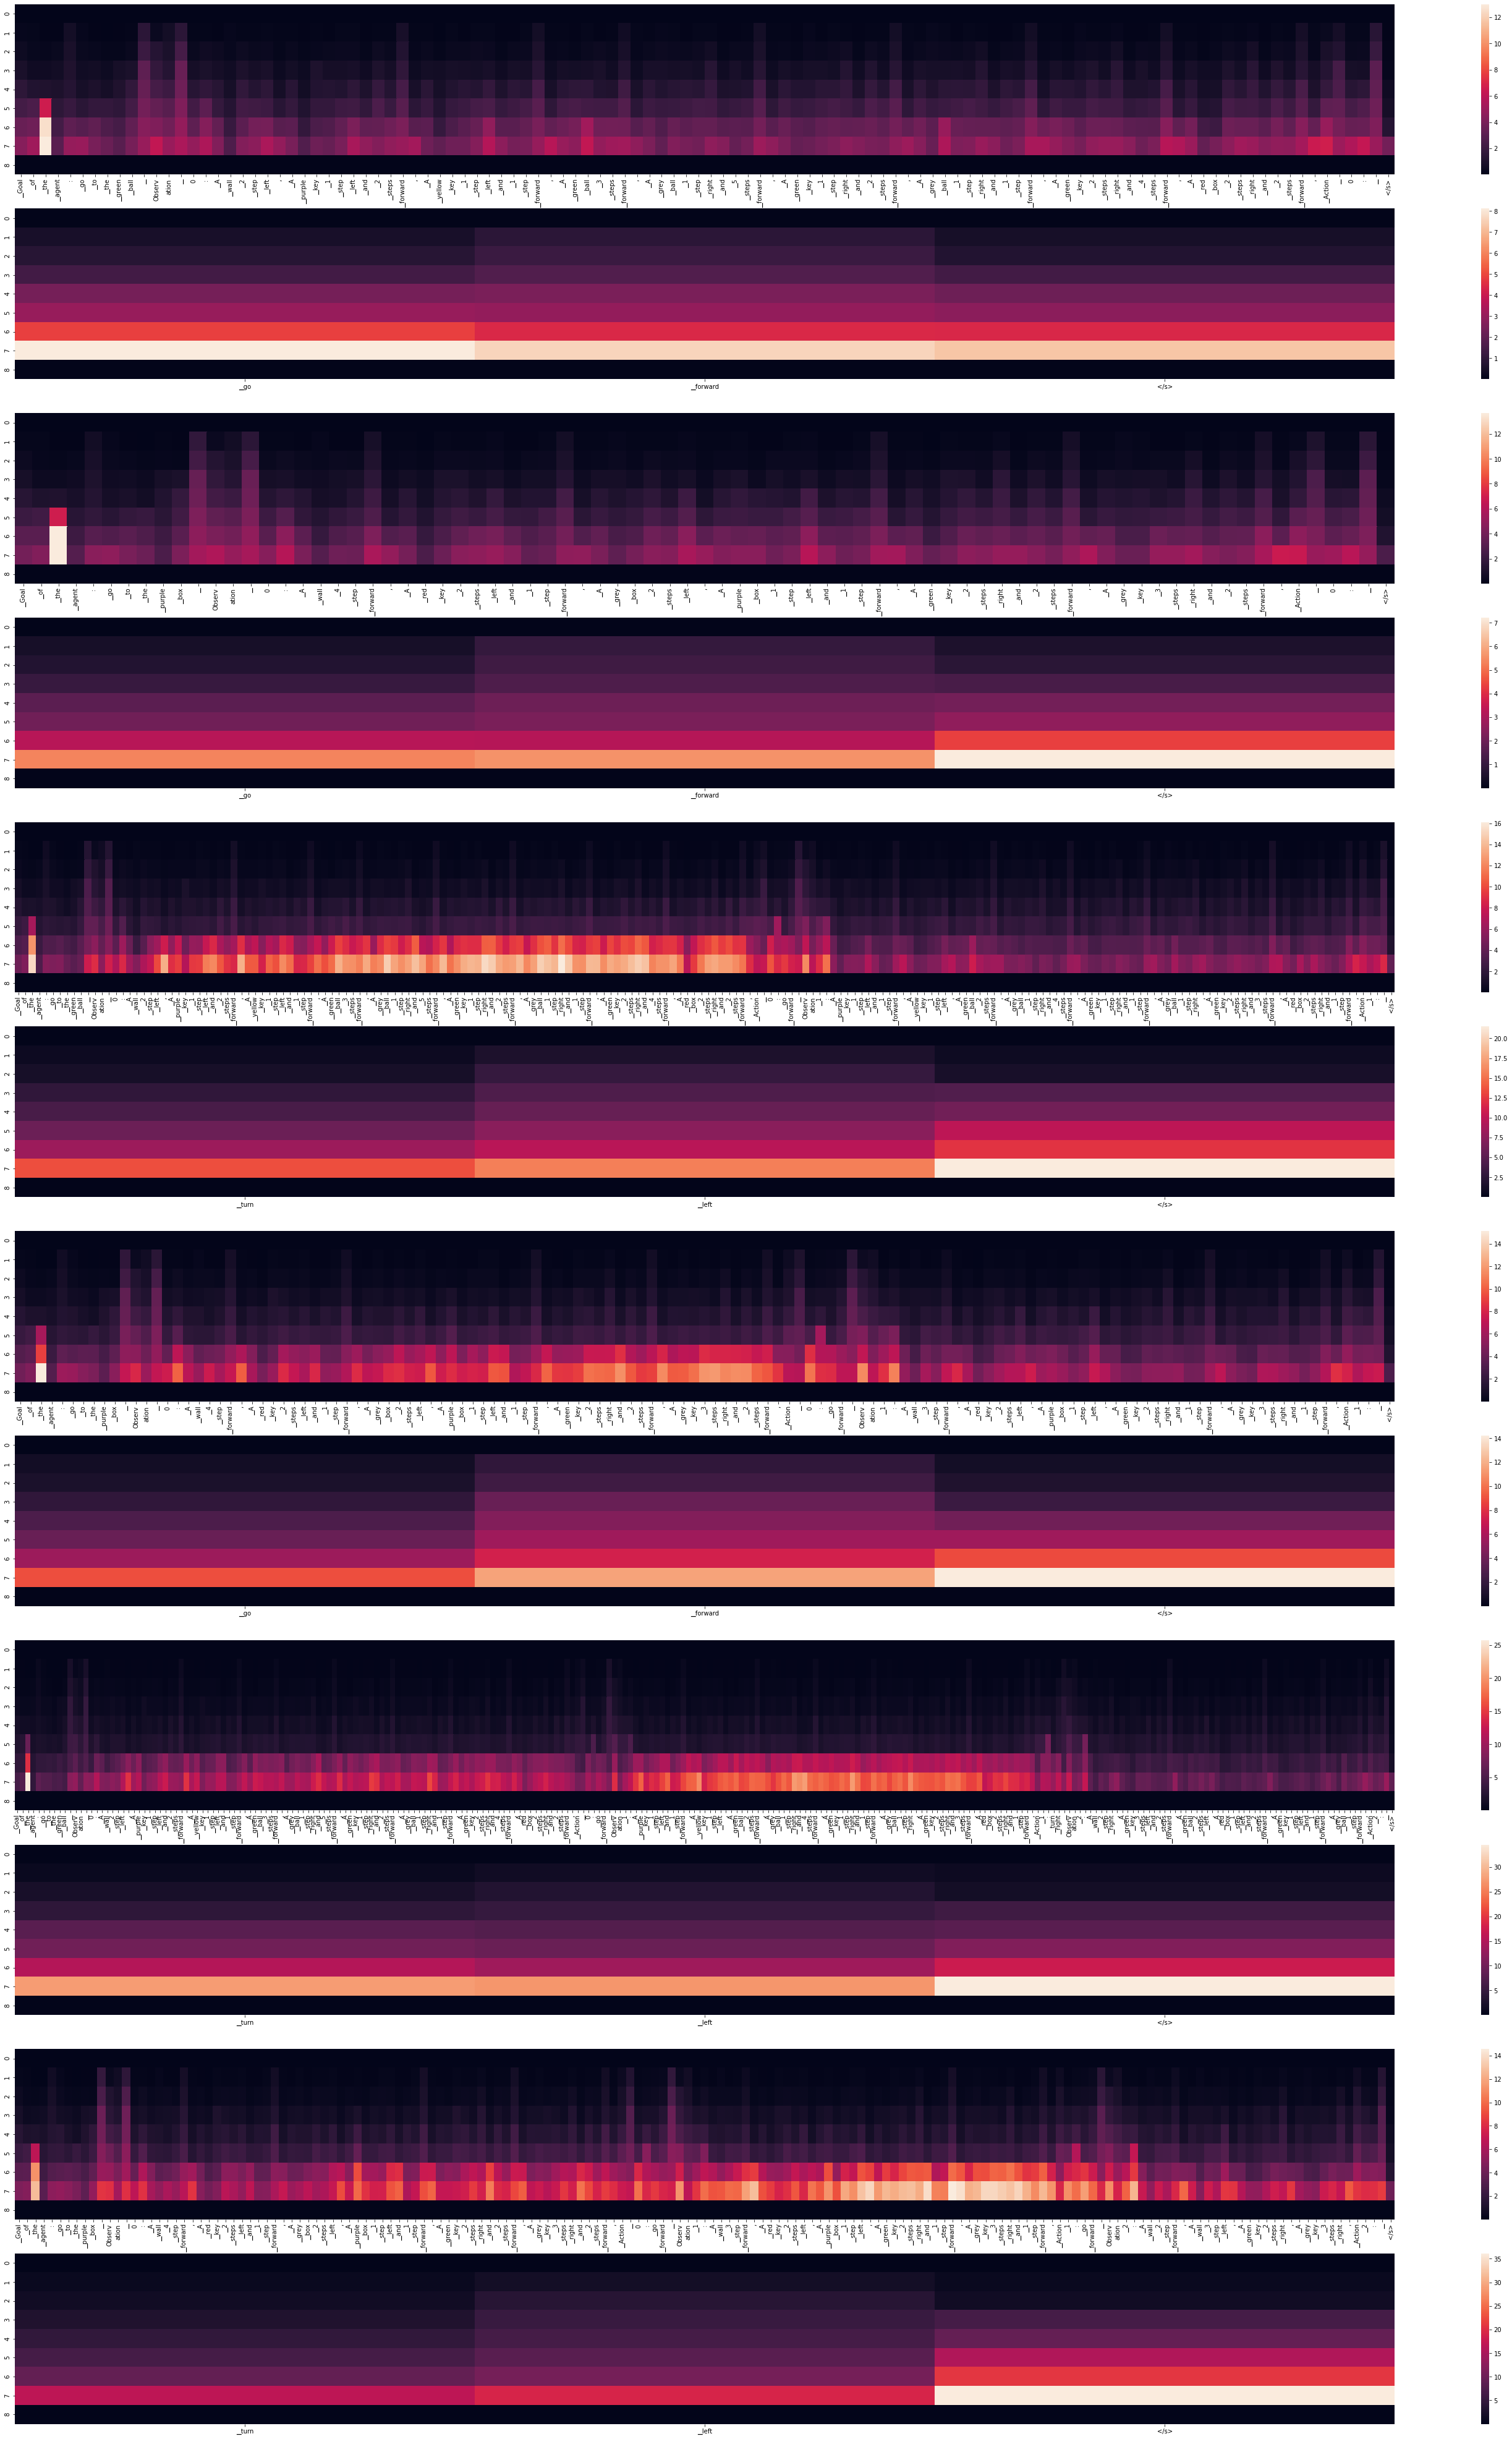

In [176]:
fig, axs = plt.subplots(len(prompts)*2)
fig.set_figwidth(50)
fig.set_figheight(6*len(prompts)*2)
representation_distances_by_tokens = {
    "encoder": {},
    "decoder": {}
}
for _idx in range(len(prompts)):
    _results = compute_representation_distances(prompts[_idx], expected_answers[_idx])
    gather_by_token(_results["encoder"], representation_distances_by_tokens["encoder"])
    gather_by_token(_results["decoder"], representation_distances_by_tokens["decoder"])
    sns.heatmap(_results["encoder"]["distances"], xticklabels=_results["encoder"]["tokens"], ax=axs[_idx*2])
    sns.heatmap(_results["decoder"]["distances"], xticklabels=_results["decoder"]["tokens"], ax=axs[_idx*2+1])

## Analysis
- Important words seem to have deep modifications in layers. 
- Moodifications around previous actions taken.
- Big modifications on old tokens => hypothesis: learned to pay attention to these old dependencies instead of just using last part of prompt 

In [245]:
encoder_distances = reduce_distances_per_token(representation_distances_by_tokens["encoder"])
decoder_distances = reduce_distances_per_token(representation_distances_by_tokens["decoder"])

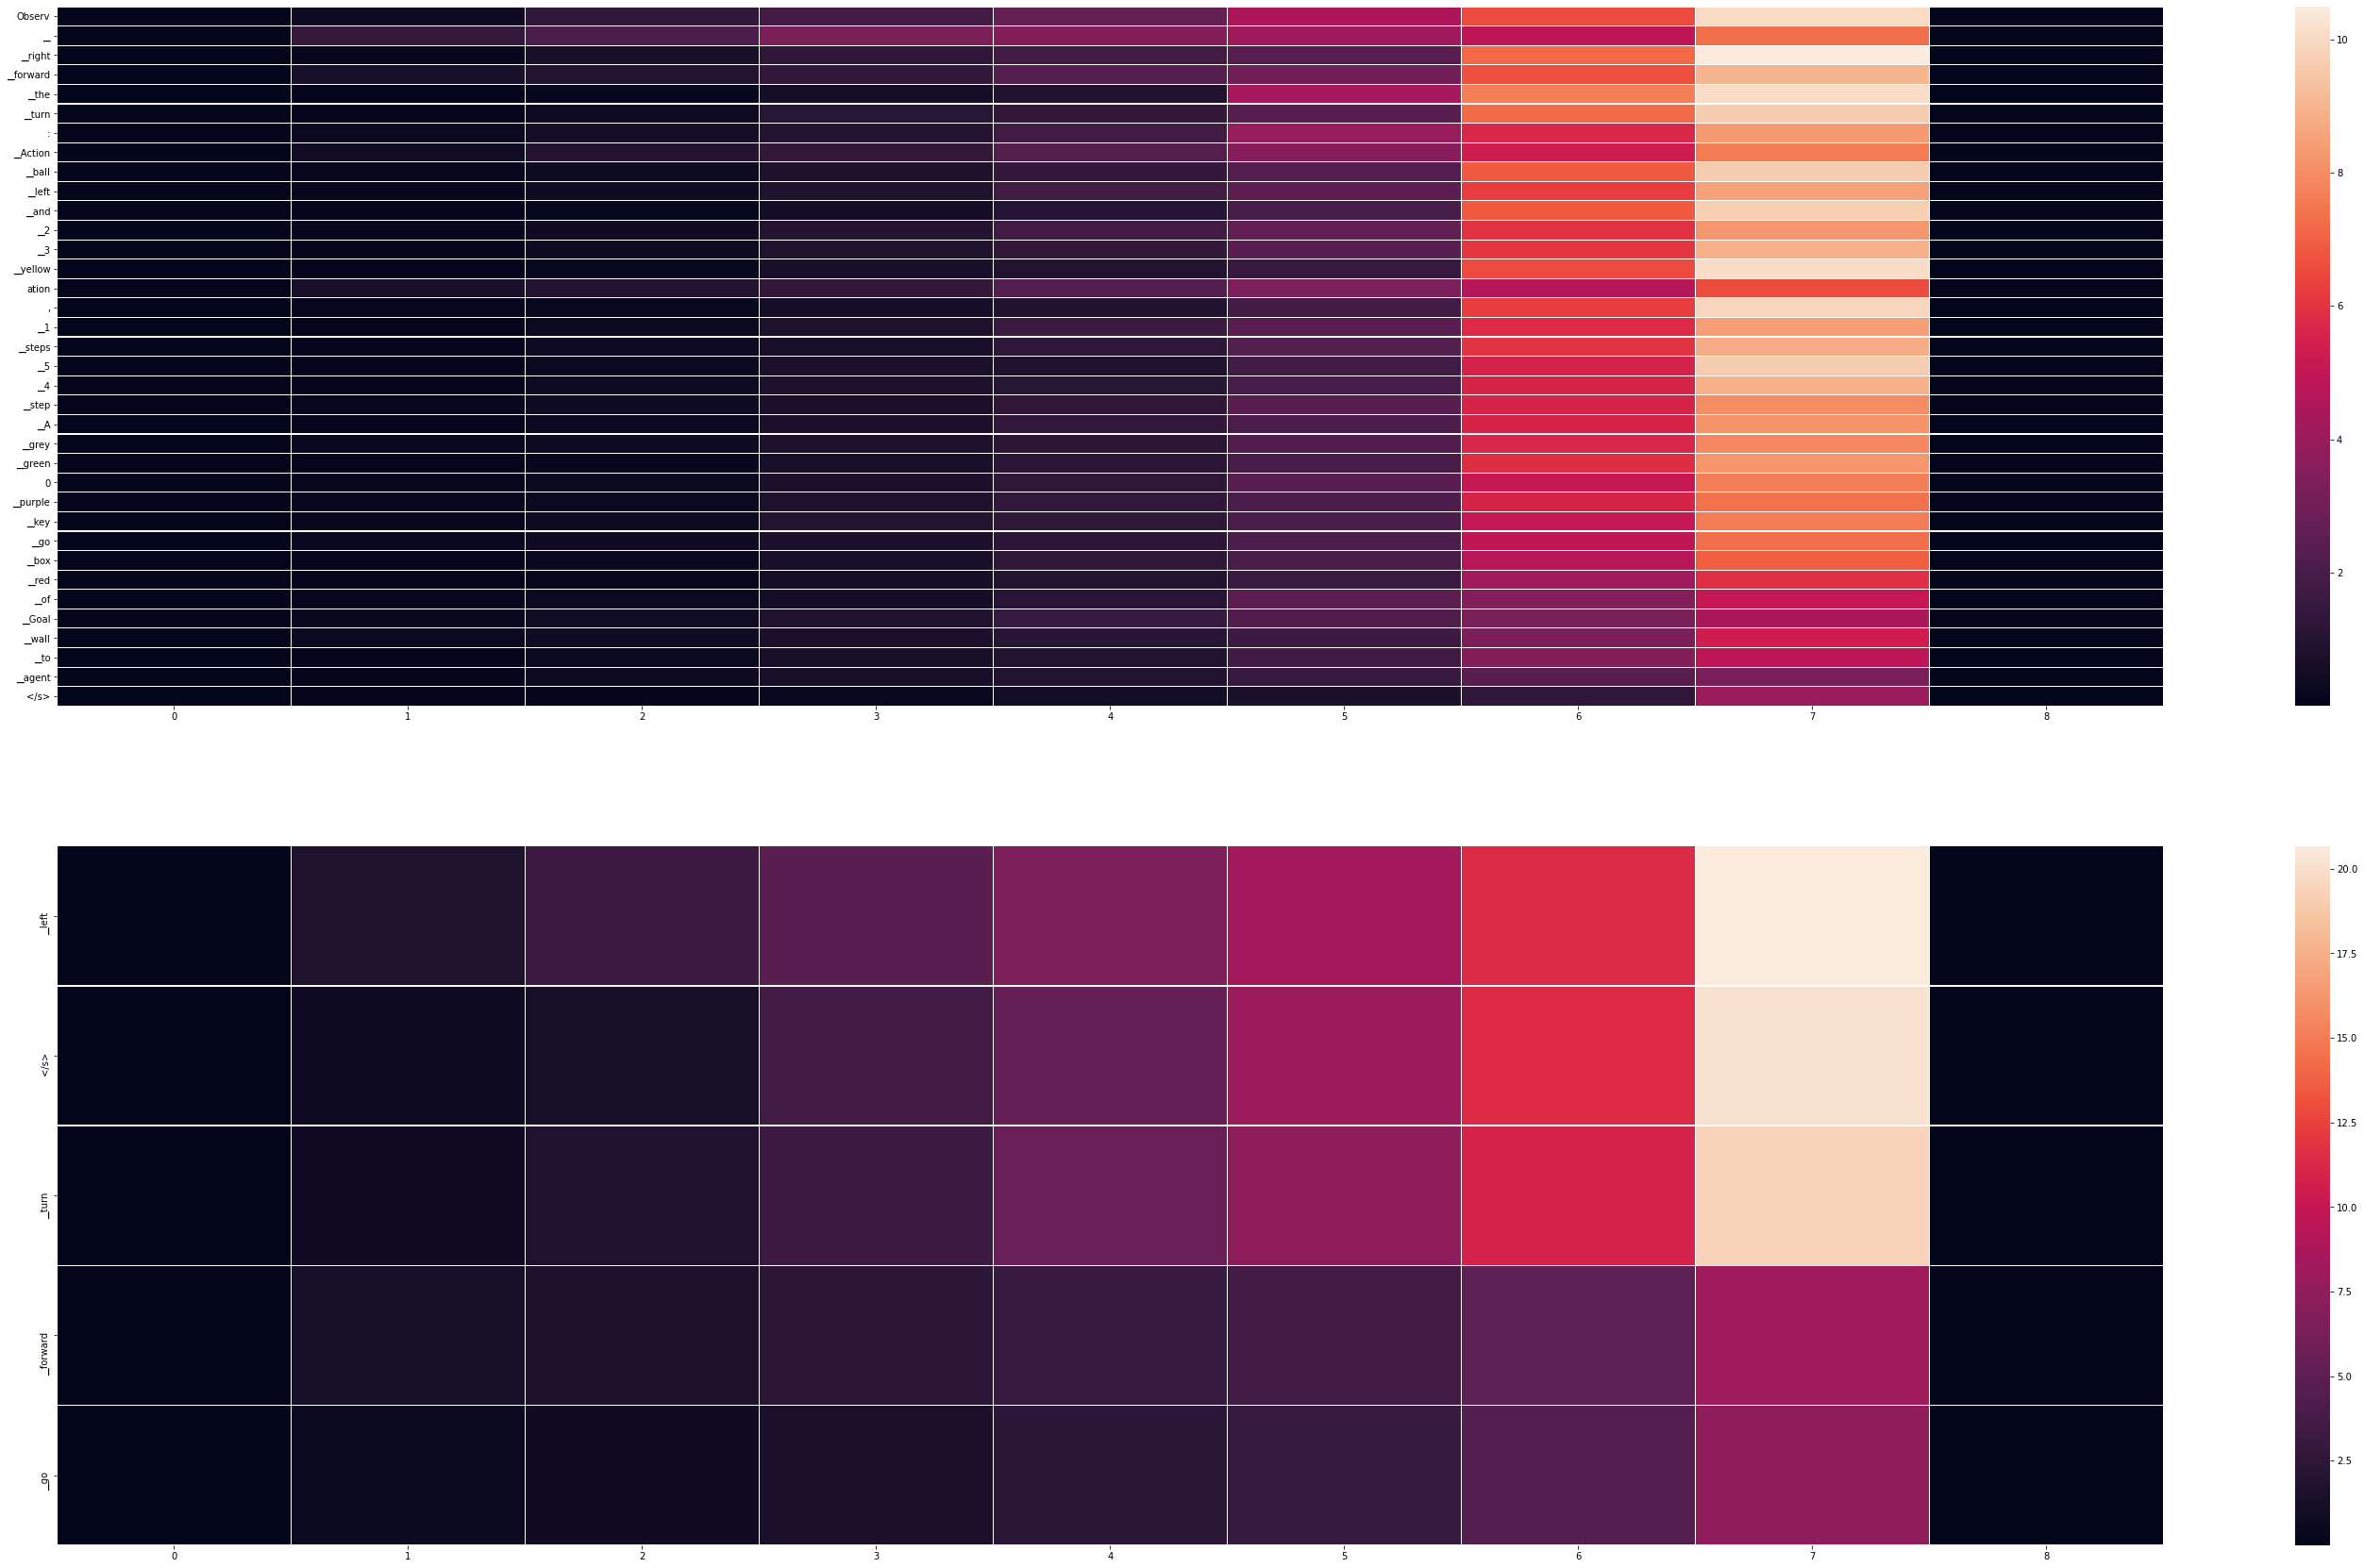

In [246]:
fig, axs = plt.subplots(2)
fig.set_figwidth(50)
fig.set_figheight(30)
sns.heatmap(list(encoder_distances.values()), yticklabels=encoder_distances.keys(), linewidth=.1, ax=axs[0])
sns.heatmap(list(decoder_distances.values()), yticklabels=decoder_distances.keys(), linewidth=.5, ax=axs[1])

## Analysis
- Interesting how some words are modified on all layers compared to some others that are only modified on last layers